In [1]:
# Imports
import numpy as np
from sklearn import model_selection, datasets, svm
import matplotlib.pyplot as plt

import copy
import qiskit
from qiskit import QuantumCircuit, Aer, IBMQ, QuantumRegister, ClassicalRegister

from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import Operator

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Load the iris dataset and do a train-test split
iris = datasets.load_iris()
X = iris.data[0:100]
Y = iris.target[0:100]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.33, random_state=42)

In [12]:
# Number of qubits
N = 4

In [9]:
# Define a feature map using angle encoding
def feature_map(X):

    q = QuantumRegister(N)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)

    for i, x in enumerate(X):
        qc.rx(x, i)
    
    return qc, c

In [10]:
# Define the variational circuit
def variational_circuit(qc, theta):
    
    for i in range(N-1):
        qc.cnot(i, i+1)
    qc.cnot(N-1, 0)
    
    for i in range(N):
        qc.ry(theta[i], i)
    
    return qc

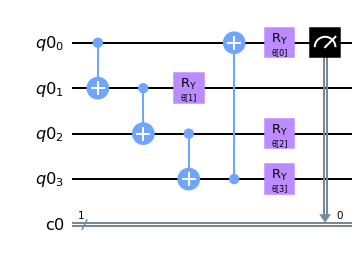

In [13]:
# Draw the variational model, adding a measurement on the first qubit
q = QuantumRegister(N)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)
qc = variational_circuit(qc, ParameterVector('θ', 4))
qc.measure(0, c)
qc.draw()

In [14]:
# Define a function, containing the variational model
def quantum_nn(X, theta, simulator=True):

    qc, c = feature_map(X)
    qc.barrier()
    qc = variational_circuit(qc, theta)
    qc.barrier()
    qc.measure(0, c)

    shots = 10000
    backend = Aer.get_backend('qasm_simulator')
    
    if not simulator:
        shots = 1000
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibmq_athens')
    
    job = backend.run(qc, shots=shots)

    result = job.result()
    counts = result.get_counts()
    
    return counts['1']/shots


In [15]:
# Define different types of loss functions
def loss(prediction, target):
    return (prediction - target)**2

def log_loss(prediction, target):
    # Write a log_loss function, similarly to the loss function above

In [17]:
# Define the gradient function
def gradient(X, Y, theta):
    delta = 0.01
    grad = []
    for i in range(len(theta)):
        dtheta = copy.copy(theta)
        dtheta[i] += delta
        
        pred1 = # Calculate the prediction of the model, passing dtheta as parametrs 
        pred2 = # Calculate the prediction of the model, passing theta as parametrs
        
        grad.append((log_loss(pred1, Y) - log_loss(pred2, Y))/delta)
        
    return np.array(grad)

In [18]:
# Define an accuracy function to check the performance of the model
def accuracy(X, Y, theta):
    
    counter = 0
    for X_i, Y_i in zip(X, Y):
        prediction = quantum_nn(X_i, theta)
        
        if prediction < 0.5 and Y_i == 0:
            counter += 1
        elif prediction >= 0.5 and Y_i == 1:
            counter += 1
            
    return counter/len(Y)

In [19]:
# Train the model
eta = 0.05
loss_list = []
theta = np.ones(N)

print('Epoch \t Loss \t Training Accuracy')

# Go through the epochs
for i in range(20):
    
    loss_tmp = []
    # For each epoch go through the data
    for X_i, Y_i in zip(X_train, Y_train):

        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(log_loss(prediction, Y_i))
        
        # Update the parameters
        theta = theta - eta * gradient(X_i, Y_i, theta)
    loss_list.append(np.mean(loss_tmp))
    acc = accuracy(X_train, Y_train, theta)
    
    print(f'{i} \t {loss_list[-1]:.3f} \t {acc:.3f}')

Epoch 	 Loss 	 Training Accuracy
0 	 0.814 	 0.179
1 	 0.768 	 0.209
2 	 0.717 	 0.806
3 	 0.612 	 0.836
4 	 0.596 	 0.836
5 	 0.601 	 0.836
6 	 0.610 	 0.821
7 	 0.598 	 0.836
8 	 0.603 	 0.836
9 	 0.605 	 0.836
10 	 0.605 	 0.836
11 	 0.612 	 0.821
12 	 0.613 	 0.791
13 	 0.616 	 0.851
14 	 0.610 	 0.821
15 	 0.611 	 0.806
16 	 0.598 	 0.821
17 	 0.608 	 0.821
18 	 0.602 	 0.836
19 	 0.606 	 0.866
20 	 0.604 	 0.851
21 	 0.596 	 0.821
22 	 0.594 	 0.806
23 	 0.597 	 0.836
24 	 0.613 	 0.806
25 	 0.613 	 0.806
26 	 0.644 	 0.836
27 	 0.610 	 0.806
28 	 0.597 	 0.836
29 	 0.594 	 0.806


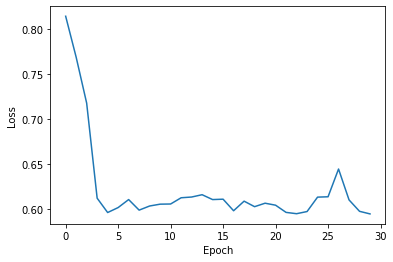

In [20]:
# Plot the loss function
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [21]:
# Check the accuracy of the model on the test set
accuracy(X_test, Y_test, theta)

0.8181818181818182